In [1]:
import numpy as np
import pandas as pd
import time
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels

from matplotlib import pyplot as plt
# %matplotlib notebook
# import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.svm.libsvm import predict_proba
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
np.random.seed(9)
stop = stopwords.words('english')

# Part I: Data Preprocessing & Cleaning

In [2]:
data = pd.read_csv('./7282_1.csv', sep = ',')

In [3]:
# Use the Regex to clean the data

# Replacing blank values (white space) with NaN in pandas
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)
data.replace(r'\w*[�]', np.nan, regex=True, inplace=True)
# Use the Regex to filter the provinces in US.
data['province'].replace(r'[A-Z][a-z]+', np.nan, regex=True, inplace=True)

In [4]:
data = data[data['reviews.rating'] < 6]

In [5]:
data.dropna(inplace=True)
data = data.reset_index()
data.shape

(25973, 15)

In [6]:
# export the new csv file with cleaning
# data.to_csv('D:/Jupyter/DAV_FinalProject//7282_2.csv', encoding='utf_8_sig')

In [7]:
data['sentiment']= np.nan

In [8]:
# 1 --> good
# 0 --> bad
def judgeSentiment(data):
    if data['reviews.rating'] < 3:
        return 0
    else:
        return 1

data['sentiment'] = data.apply(lambda r : judgeSentiment(r), axis=1)

In [9]:
data['sentiment'].value_counts()

1    21406
0     4567
Name: sentiment, dtype: int64

# Part II: Visualization

## Wordcloud drawing

In [10]:
# tokens_1 = nltk.word_tokenize(str(data[data['sentiment']==1]['reviews.text']))

In [11]:
# tokens_1

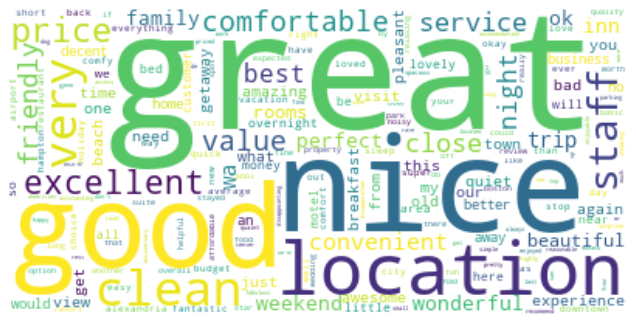

In [12]:
# wordcloud --> 1
tx1 = data[data['sentiment'] == 1]['reviews.title'].str.cat(sep=',').lower()
wordcloud = WordCloud(background_color="white",
                      collocations=False, # avoid repetition
                      stopwords=['place','stay','hotel','in','and','with','for','the','to',
                                'but','is','at','room','it','on','Not','of']).generate(tx1)

# Set the size of the figure
plt.figure(num = 1, figsize=(10, 8),dpi=80, frameon=False, clear=True)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# plt.savefig('wordcloud_good.png')

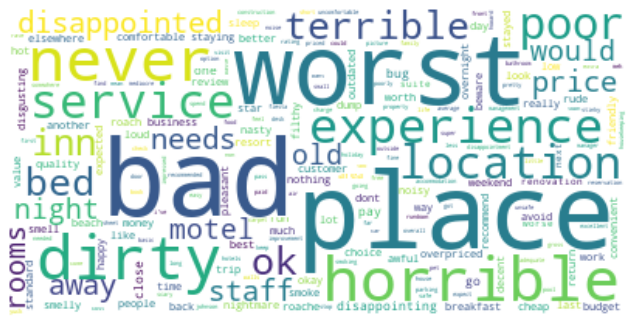

In [13]:
# wordcloud --> 0
tx2 = data[data['sentiment'] == 0]['reviews.title'].str.cat(sep=',').lower()
wordcloud1 = WordCloud(background_color="white",
                       collocations=False, 
                       stopwords=stop+['stay','room','hotel','need','and','it','for','in','was','is',
                                 'the','here','to','you','get','with','clean','Nice',
                                  'what you','Great','of','do','on','good','ever','else']).generate(tx2)
plt.figure(num = 2, figsize=(10, 8),dpi=80, frameon=False, clear=True)

# wordcloud1 = WordCloud(background_color="white", stopwords=stop).generate(tx2)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()
# plt.savefig('wordcloud_bad.png')

In [14]:
# data['province'].value_counts()
type(tx2)

str

## Drawing the Confusion Matirx
This idea is offered by sklearn official.

We meet the problem when we plot the confusion matrix, and the problem is: top and bottom boxes are cut off. At last, we resolve this problem from Github (https: //github.com/mwaskom/seaborn/issues/1773)

In [15]:
# Drawing the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    '''
    We meet the problem when we plot the confusion matrix, and the problem is: 
    top and bottom boxes are cut off. At last, we resolve this problem from Github:
    https: //github.com/mwaskom/seaborn/issues/1773
    '''
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]),
#                       title='Confusion matrix of MultinomialNB()')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]), normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

# Part III: Classification

In [16]:
# vect = TfidfVectorizer(ngram_range = (1,2))
vect = TfidfVectorizer()

In [17]:
# reviews.text	reviews.title
reviews_text = vect.fit_transform(data['reviews.text'])
reviews_title= vect.fit_transform(data['reviews.title'])

In [18]:
data_model = pd.DataFrame({'reviews_rating' : data['reviews.rating'], 
                           'reviews_text' : reviews_text,
                           'reviews_title' : reviews_title, 
                           'sentiment' : data['sentiment']})

In [19]:
# Remove the stop words
stop = stopwords.words('english')
data['reviews.text'] = data['reviews.text'].str.lower().str.split()
data['reviews.text'] = data['reviews.text'].apply(lambda x: 
                                                  ' '.join([word for word in x if word not in stop]))

data['reviews.text'] = pd.DataFrame(data['reviews.text'])

In [20]:
data['reviews.text']

0        pleasant 10 min walk along sea front water bus...
1        really lovely hotel. stayed top floor surprise...
2        stayed four nights october. hotel staff welcom...
3        loved staying island lido! need take water ven...
4        lovely view onto lagoon. excellent view. staff...
                               ...                        
25968    truly enjoyed staying elk springs resort! quie...
25969    2nd time last weekend april (we stayed deer he...
25970    best best!!!! family stayed grin bear cabin ch...
25971    amazing vacation beautiful cabin stayed long w...
25972    husband stayed tree tops bearfoot resort, mana...
Name: reviews.text, Length: 25973, dtype: object

In [21]:
# Splict training and testing data
X = data['reviews.text']
y = data_model.iloc[:,3]  # Choose the column of "sentiment" from data_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train =  vect.fit_transform(X_train)
X_test = vect.transform(X_test)
X = vect.transform(X)
# y = data_model.iloc[:,3]  # Choose the column of "sentiment" from data_model

## 1. Naive Bayes

### MultinomialNB(): 
MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

In [22]:
start = time.time()
mnb = MultinomialNB()

# # Splict training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
clf_mnb = mnb.fit(X_train, y_train)
clf_mnb = mnb.fit(X_test, y_test)
y_pred = mnb.fit(X_train, y_train).predict(X_test)

end = time.time()
print('The time of running is: {0}\'s'.format(end-start))

print('The Accuarcy of Training Set is: {0}\nThe Accuarcy of Testing Set is: {1}'.format(clf_mnb.score(X_train, y_train), clf_mnb.score(X_test, y_test)))

The time of running is: 0.020945072174072266's
The Accuarcy of Training Set is: 0.8493482206699301
The Accuarcy of Testing Set is: 0.8415041067761807


In [23]:
# ROC Curve
y_pred_mnb = mnb.predict_proba(X_test)[:,1]
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_pred_mnb)

In [24]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred),'\n'
      'F1 Score: ', f1_score(y_test, y_pred, average='weighted'), '\n'
      'Recall Score: ', recall_score(y_test, y_pred, average='weighted'),'\n'
      'Precision: ', precision_score(y_test, y_pred, average='weighted'))

Confusion Matrix:  [[ 143 1219]
 [  16 6414]] 
F1 Score:  0.7856039210230259 
Recall Score:  0.8415041067761807 
Precision:  0.8506242372327076


In [25]:
# Cross Validation
val_scores_mnb = cross_val_score(mnb, X_train, y_train, cv = 10)
print('Score of each Validation is: {0} \nScore of mean is: {1}'.format(val_scores_mnb,
                                                                        val_scores_mnb.mean()))

Score of each Validation is: [0.84 0.84 0.83 0.84 0.83 0.83 0.83 0.83 0.83 0.83] 
Score of mean is: 0.8325722374326492


Confusion matrix, without normalization
[[ 143 1219]
 [  16 6414]]


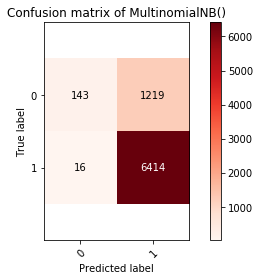

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]),
                      title='Confusion matrix of MultinomialNB()')

### ComplementNB():
This Class if good to use in the imbalanced dataset

In [27]:
start = time.time()
cnb = ComplementNB()
clf_cnb = cnb.fit(X_train, y_train)
clf_cnb = cnb.fit(X_test, y_test)
y_pred = cnb.fit(X_train, y_train).predict(X_test)

end = time.time()
print('The time of running is: {0}\'s'.format(end-start))
print('The Accuarcy of Training Set is: {0}\nThe Accuarcy of Testing Set is: {1}'.format(clf_cnb.score(X_train, y_train), 
                clf_cnb.score(X_test, y_test)))

The time of running is: 0.01994609832763672's
The Accuarcy of Training Set is: 0.8822397007865354
The Accuarcy of Testing Set is: 0.8516427104722792


In [28]:
# ROC Curve
y_pred_cnb = cnb.predict_proba(X_test)[:,1]
fpr_cnb, tpr_cnb, _ = roc_curve(y_test, y_pred_cnb)

In [29]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred),'\n'
      'F1 Score: ', f1_score(y_test, y_pred, average='weighted'), '\n'
      'Recall Score: ', recall_score(y_test, y_pred, average='weighted'),'\n'
      'Precision: ', precision_score(y_test, y_pred, average='weighted'))

Confusion Matrix:  [[ 610  752]
 [ 404 6026]] 
F1 Score:  0.8427325958025726 
Recall Score:  0.8516427104722792 
Precision:  0.8388037386784878


In [30]:
# Cross Validation
val_scores_cnb = cross_val_score(cnb, X_train, y_train, cv = 10)
print('Score of each Validation is: {0} \nScore of mean is: {1}'.format(val_scores_cnb, 
                                                                        val_scores_cnb.mean()))

Score of each Validation is: [0.84 0.85 0.85 0.87 0.86 0.85 0.85 0.85 0.85 0.85] 
Score of mean is: 0.8534190197469446


Confusion matrix, without normalization
[[ 610  752]
 [ 404 6026]]


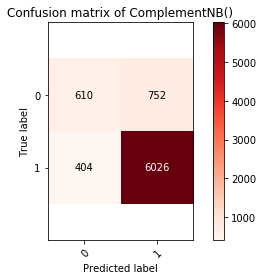

In [31]:
plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]), title='Confusion matrix of ComplementNB()')

## 2. Logistic Regression
Logistic Regression is good algorithm to simulate the unbalanced data.

In [32]:
start = time.time()
lgt = LogisticRegression(random_state=0, solver='lbfgs', class_weight=0.8) # threshold=0.8
clf_lgt = lgt.fit(X_train, y_train)
clf_lgt = lgt.fit(X_test, y_test)
y_pred = lgt.fit(X_train, y_train).predict(X_test)

end = time.time()
print('The time of running is: {0}\'s'.format(end-start))
print('The Accuarcy of Training Set is: {0}\nThe Accuarcy of Testing Set is: {1}'.format(clf_lgt.score(X_train, y_train), 
                                                                                         clf_lgt.score(X_test, y_test)))

The time of running is: 1.125143051147461's
The Accuarcy of Training Set is: 0.9106759804191189
The Accuarcy of Testing Set is: 0.8848819301848049


In [33]:
# ROC Curve
y_pred_lgt = lgt.predict_proba(X_test)[:,1]
fpr_lgt, tpr_lgt, _ = roc_curve(y_test, y_pred_lgt)

In [34]:
# Cross Validation
val_scores_lgt = cross_val_score(lgt, X_train, y_train, cv = 10)
print('Score of each Validation is: {0} \nScore of mean is: {1}'.format(val_scores_lgt, 
                                                                        val_scores_lgt.mean()))

Score of each Validation is: [0.88 0.88 0.88 0.89 0.89 0.88 0.89 0.89 0.89 0.88] 
Score of mean is: 0.883119843045327


In [35]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred),'\n'
      'F1 Score: ', f1_score(y_test, y_pred, average='weighted'), '\n'
      'Recall Score: ', recall_score(y_test, y_pred, average='weighted'),'\n'
      'Precision: ', precision_score(y_test, y_pred, average='weighted'))

Confusion Matrix:  [[ 643  719]
 [ 178 6252]] 
F1 Score:  0.8729410796738218 
Recall Score:  0.8848819301848049 
Precision:  0.8769899966475854


Confusion matrix, without normalization
[[ 643  719]
 [ 178 6252]]


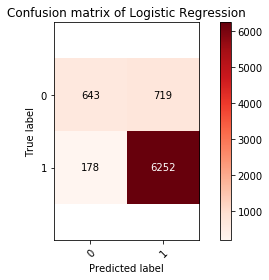

In [36]:
# Confusion Matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]),
                      title='Confusion matrix of Logistic Regression')

## 3.Support Vector Machine

In [37]:
start = time.time()
svm = svm.SVC(gamma='auto', probability=True)
# It will be really really slow when we set the probability=True.

clf_svm = svm.fit(X_train, y_train)
clf_svm = svm.fit(X_test, y_test)
y_pred = svm.fit(X_train, y_train).predict(X_test)

end = time.time()
print('The time of running is: {0}\'s'.format(end-start))
print('The Accuarcy of Training Set is: {0}\nThe Accuarcy of Testing Set is: {1}'.format(clf_svm.score(X_train, y_train), 
                                                                                         clf_svm.score(X_test, y_test)))

The time of running is: 423.3219406604767's
The Accuarcy of Training Set is: 0.8237170672680271
The Accuarcy of Testing Set is: 0.8252053388090349


In [38]:
# ROC
y_pred_svm = svm.predict_proba(X_test)[:,1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)

In [39]:
# Cross Validation
val_scores_svm = cross_val_score(lgt, X_train, y_train, cv = 10)
print('Score of each Validation is: {0} \nScore of mean is: {1}'.format(val_scores_lgt, 
                                                                        val_scores_lgt.mean()))

Score of each Validation is: [0.88 0.88 0.88 0.89 0.89 0.88 0.89 0.89 0.89 0.88] 
Score of mean is: 0.883119843045327


In [40]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred),'\n'
      'F1 Score: ', f1_score(y_test, y_pred, average='weighted'), '\n'
      'Recall Score: ', recall_score(y_test, y_pred, average='weighted'),'\n'
      'Precision: ', precision_score(y_test, y_pred, average='weighted'))

Confusion Matrix:  [[   0 1362]
 [   0 6430]] 
F1 Score:  0.746177798979341 
Recall Score:  0.8252053388090349 
Precision:  0.6809638511989341


Confusion matrix, without normalization
[[   0 1362]
 [   0 6430]]


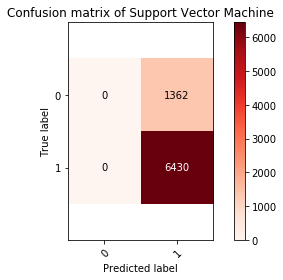

In [41]:
# Confusion Matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]),
                      title='Confusion matrix of Support Vector Machine')

## 4. Random Forest

### RandomForestClassifier()

In [42]:
start = time.time()
rfc = RandomForestClassifier()
clf_rfc = rfc.fit(X_train, y_train)
clf_rfc = rfc.fit(X_test, y_test)
y_pred = rfc.fit(X_train, y_train).predict(X_test)

end = time.time()
print('The time of running is: {0}\'s'.format(end-start))
print('The Accuarcy of Training Set is: {0}\nThe Accuarcy of Testing Set is: {1}'.format(clf_rfc.score(X_train, y_train), 
                                                                                         clf_rfc.score(X_test, y_test)))

The time of running is: 72.52736735343933's
The Accuarcy of Training Set is: 0.9943897475386393
The Accuarcy of Testing Set is: 0.8624229979466119


In [43]:
# ROC
y_pred_rfc = rfc.predict_proba(X_test)[:,1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_rfc)

In [44]:
# Cross Validation
val_scores_rfc = cross_val_score(rfc, X_train, y_train, cv = 10)
print('Score of each Validation is: {0} \nScore of mean is: {1}'.format(val_scores_rfc, 
                                                                        val_scores_rfc.mean()))

Score of each Validation is: [0.85 0.87 0.85 0.86 0.87 0.87 0.86 0.85 0.86 0.87] 
Score of mean is: 0.8608440970540154


In [45]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred),'\n'
      'F1 Score: ', f1_score(y_test, y_pred, average='weighted'), '\n'
      'Recall Score: ', recall_score(y_test, y_pred, average='weighted'),'\n'
      'Precision: ', precision_score(y_test, y_pred, average='weighted'))

Confusion Matrix:  [[ 374  988]
 [  84 6346]] 
F1 Score:  0.8327734539034798 
Recall Score:  0.8624229979466119 
Precision:  0.8567740319278919


Confusion matrix, without normalization
[[ 374  988]
 [  84 6346]]


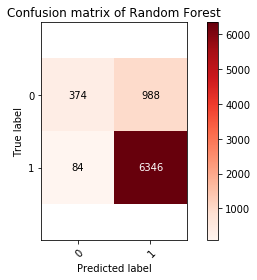

In [46]:
# Confusion Matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0,1]),
                      title='Confusion matrix of Random Forest')

## ROC Curve

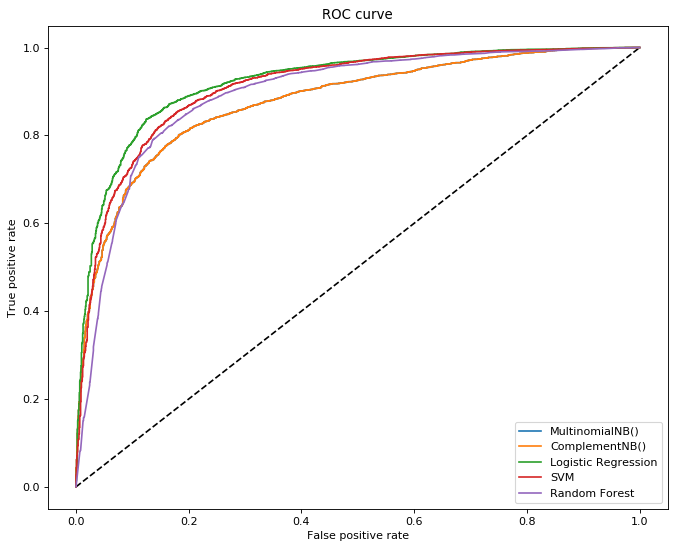

In [47]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mnb, tpr_mnb, label='MultinomialNB()')
plt.plot(fpr_cnb, tpr_cnb, label='ComplementNB()')
plt.plot(fpr_lgt, tpr_lgt, label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot(fpr_rfc, tpr_rfc, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

We can find the "MultinomialNB()" and "ComplementNB()" are overlap, and they have the same results. But compared with F-score, precision and recall, the "ComplementNB()" is better than "MultinomialNB()".